In [52]:
    import yfinance as yf
    import pandas as pd
    from datetime import timedelta
    import pandas as pd
    import yfinance as yf
    import pandas as pd
    import numpy as np
    import yfinance as yf
    import matplotlib.pyplot as plt
    import json
    # Assuming companies variable contains your JSON with publish and effective dates

    with open('companies.json', 'r') as file:
        companies = json.load(file)





    def calculate_sharpe_ratio(returns, risk_free_rate=0):
        mean_return = np.mean(returns)
        std_return = np.std(returns)
        if std_return != 0:
            return (mean_return - risk_free_rate) / std_return
        else:
            return np.nan

    def annualize_return(cumulative_return, holding_period_days, periods_per_year=252):
        return (1 + cumulative_return) ** (periods_per_year / holding_period_days) - 1

    def annualize_std(cumulative_std, holding_period_days, periods_per_year=252):
        return cumulative_std * np.sqrt(periods_per_year / holding_period_days)

    def download_and_align_data(ticker, publish_date):
        publish_date = pd.to_datetime(publish_date)
        start_date = publish_date + pd.DateOffset(1)
        end_date = publish_date + pd.DateOffset(months=6)  # Increased to 6 months to cover longer holding periods
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if 'Close' not in stock_data.columns or 'Open' not in stock_data.columns:
            raise ValueError(f"Data for {ticker} does not contain 'Close' or 'Open' prices.")
        stock_data = stock_data.reset_index()
        stock_data['Days Since Publish'] = (stock_data['Date'] - stock_data['Date'].iloc[0]).dt.days
        return stock_data[['Date', 'Days Since Publish', 'Open', 'Close']]

    def simulate_trade(data, holding_periods):
        tickers = data['Ticker'].unique()
        results = []

        for holding_period in holding_periods:
            returns = []
            for ticker in tickers:
                ticker_data = data[data['Ticker'] == ticker].reset_index(drop=True)
                if len(ticker_data) >= holding_period:
                    start_price = ticker_data['Open'].iloc[0]
                    end_price = ticker_data['Close'].iloc[holding_period - 1]
                    cumulative_return = (end_price - start_price) / start_price
                    returns.append(cumulative_return)
            if len(returns) > 0:
                avg_return = np.mean(returns)
                std_deviation = np.std(returns)
                sharpe_ratio = calculate_sharpe_ratio(returns)
                annualized_ret = annualize_return(avg_return, holding_period)
                annualized_std_dev = annualize_std(std_deviation, holding_period)
                annualized_sharpe = annualize_sharpe(annualized_ret, annualized_std_dev)
                results.append({
                    'Holding Period': holding_period,
                    'Average Return': avg_return,
                    'Standard Deviation': std_deviation,
                    'Sharpe Ratio': sharpe_ratio,
                    'Annualized Return': annualized_ret,
                    'Annualized Std Dev': annualized_std_dev,
                    'Annualized Sharpe Ratio': annualized_sharpe
                })
        return pd.DataFrame(results)

    def annualize_sharpe(annualized_return, annualized_std):
        if annualized_std != 0:
            return annualized_return / annualized_std
        else:
            return np.nan
        
        
    def download_intraday_data(ticker, publish_date, interval='1m'):
        publish_date = pd.to_datetime(publish_date)
        
        # Define the start and end time for the publish date
        # Assuming publish_date is the date when the news is released before market opens or during trading hours
        start_datetime = publish_date + timedelta(days=1, hours=9, minutes=30)
        end_datetime = publish_date + timedelta(days=1, hours=17)
        
        try:
            intraday_data = yf.download(
                ticker,
                start=start_datetime,
                end=end_datetime,
                interval=interval,
                prepost=True,  # Include pre-market and post-market data
                progress=False
            )
            
            if intraday_data.empty:
                raise ValueError(f"No intraday data found for {ticker} on {publish_date.date()}")
            
            # Reset index to have 'Datetime' as a column
            intraday_data = intraday_data.reset_index()
            
            # Add 'Ticker' column for identification
            intraday_data['Ticker'] = ticker
            
            return intraday_data
        except Exception as e:
            print(f"Error fetching intraday data for {ticker} on {publish_date.date()}: {e}")
            return pd.DataFrame()  # Return empty DataFrame on failure



In [53]:

# Download and align data
aligned_data = {}
aligned_data_intraday = {}

for company in companies:
    ticker = company['ticker']
    publish_date = company['publish_date']
    try:
        aligned_data[ticker] = download_and_align_data(ticker, publish_date)
        print(f"Successfully downloaded and aligned data for {ticker}")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")


      # Download intraday data for publish date
    try:
        intraday = download_intraday_data(ticker, publish_date, interval='1h')  # You can change interval if needed
        if not intraday.empty:
            aligned_data_intraday[ticker] = intraday
            print(f"Successfully downloaded intraday data for {ticker} on {publish_date}")
        else:
            print(f"No intraday data for {ticker} on {publish_date}")
    except Exception as e:
        print(f"Error downloading intraday data for {ticker}: {e}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Successfully downloaded and aligned data for SW
Successfully downloaded intraday data for SW on 2024-07-08
Successfully downloaded and aligned data for CRWD



1 Failed download:
['CRWD']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['KKR']: IndexError('index 0 is out of bounds for axis 0 with size 0')


Error fetching intraday data for CRWD on 2024-06-07: No intraday data found for CRWD on 2024-06-07
No intraday data for CRWD on 2024-06-07
Successfully downloaded and aligned data for KKR
Error fetching intraday data for KKR on 2024-06-07: No intraday data found for KKR on 2024-06-07
No intraday data for KKR on 2024-06-07


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GDDY']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed


Successfully downloaded and aligned data for GDDY
Error fetching intraday data for GDDY on 2024-06-07: No intraday data found for GDDY on 2024-06-07
No intraday data for GDDY on 2024-06-07
Successfully downloaded and aligned data for VST



1 Failed download:
['VST']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed


Error fetching intraday data for VST on 2024-05-03: No intraday data found for VST on 2024-05-03
No intraday data for VST on 2024-05-03
Successfully downloaded and aligned data for GEV



1 Failed download:
['GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1711632600, endDate = 1711659600")
[*********************100%%**********************]  1 of 1 completed


Error fetching intraday data for GEV on 2024-03-27: No intraday data found for GEV on 2024-03-27
No intraday data for GEV on 2024-03-27
Successfully downloaded and aligned data for SOLV



1 Failed download:
['SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1711632600, endDate = 1711659600")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DECK']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SMCI']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed


Error fetching intraday data for SOLV on 2024-03-27: No intraday data found for SOLV on 2024-03-27
No intraday data for SOLV on 2024-03-27
Successfully downloaded and aligned data for DECK
Error fetching intraday data for DECK on 2024-03-01: No intraday data found for DECK on 2024-03-01
No intraday data for DECK on 2024-03-01
Successfully downloaded and aligned data for SMCI
Error fetching intraday data for SMCI on 2024-03-01: No intraday data found for SMCI on 2024-03-01
No intraday data for SMCI on 2024-03-01
Successfully downloaded and aligned data for BLDR



1 Failed download:
['BLDR']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['UBER']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['JBL']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed


Error fetching intraday data for BLDR on 2023-12-01: No intraday data found for BLDR on 2023-12-01
No intraday data for BLDR on 2023-12-01
Successfully downloaded and aligned data for UBER
Error fetching intraday data for UBER on 2023-12-01: No intraday data found for UBER on 2023-12-01
No intraday data for UBER on 2023-12-01
Successfully downloaded and aligned data for JBL
Error fetching intraday data for JBL on 2023-12-01: No intraday data found for JBL on 2023-12-01
No intraday data for JBL on 2023-12-01
Successfully downloaded and aligned data for LULU



1 Failed download:
['LULU']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['HUBB']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed


Error fetching intraday data for LULU on 2023-10-13: No intraday data found for LULU on 2023-10-13
No intraday data for LULU on 2023-10-13
Successfully downloaded and aligned data for HUBB
Error fetching intraday data for HUBB on 2023-10-13: No intraday data found for HUBB on 2023-10-13
No intraday data for HUBB on 2023-10-13
Successfully downloaded and aligned data for VLTO



1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1695994200, endDate = 1696021200")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ABNB']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BX']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed

Error fetching intraday data for VLTO on 2023-09-28: No intraday data found for VLTO on 2023-09-28
No intraday data for VLTO on 2023-09-28
Successfully downloaded and aligned data for ABNB
Error fetching intraday data for ABNB on 2023-09-01: No intraday data found for ABNB on 2023-09-01
No intraday data for ABNB on 2023-09-01
Successfully downloaded and aligned data for BX
Error fetching intraday data for BX on 2023-09-01: No intraday data found for BX on 2023-09-01
No intraday data for BX on 2023-09-01



[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PANW']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed

Successfully downloaded and aligned data for KVUE
Successfully downloaded intraday data for KVUE on 2023-08-09
Successfully downloaded and aligned data for PANW
Error fetching intraday data for PANW on 2023-06-02: No intraday data found for PANW on 2023-06-02
No intraday data for PANW on 2023-06-02
Successfully downloaded and aligned data for AXON



[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FICO']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed


Successfully downloaded intraday data for AXON on 2023-05-01
Successfully downloaded and aligned data for FICO
Error fetching intraday data for FICO on 2023-03-03: No intraday data found for FICO on 2023-03-03
No intraday data for FICO on 2023-03-03
Successfully downloaded and aligned data for BG


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PODD']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GEHC']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed

Successfully downloaded intraday data for BG on 2023-03-13
Successfully downloaded and aligned data for PODD
Error fetching intraday data for PODD on 2023-03-10: No intraday data found for PODD on 2023-03-10
No intraday data for PODD on 2023-03-10
Successfully downloaded and aligned data for GEHC
Error fetching intraday data for GEHC on 2022-12-28: No intraday data found for GEHC on 2022-12-28
No intraday data for GEHC on 2022-12-28



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Successfully downloaded and aligned data for STLD
Successfully downloaded intraday data for STLD on 2022-12-19
Successfully downloaded and aligned data for FSLR
Successfully downloaded intraday data for FSLR on 2022-12-12
Successfully downloaded and aligned data for ACGL


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['EQT']: IndexError('index 0 is out of bounds for axis 0 with size 0')


Successfully downloaded intraday data for ACGL on 2022-10-27
Successfully downloaded and aligned data for TRGP
Successfully downloaded intraday data for TRGP on 2022-10-06
Successfully downloaded and aligned data for EQT
Error fetching intraday data for EQT on 2022-09-23: No intraday data found for EQT on 2022-09-23
No intraday data for EQT on 2022-09-23


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PCG']: IndexError('index 0 is out of bounds for axis 0 with size 0')
[*********************100%%**********************]  1 of 1 completed


Successfully downloaded and aligned data for PCG
Error fetching intraday data for PCG on 2022-09-23: No intraday data found for PCG on 2022-09-23
No intraday data for PCG on 2022-09-23
Successfully downloaded and aligned data for CSGP



1 Failed download:
['CSGP']: Exception('%ticker%: 1h data not available for startTime=1662211800 and endTime=1662238800. The requested range must be within the last 730 days.')
[*********************100%%**********************]  1 of 1 completed


Error fetching intraday data for CSGP on 2022-09-02: No intraday data found for CSGP on 2022-09-02
No intraday data for CSGP on 2022-09-02
Successfully downloaded and aligned data for INVH



1 Failed download:
['INVH']: Exception('%ticker%: 1h data not available for startTime=1662211800 and endTime=1662238800. The requested range must be within the last 730 days.')
[*********************100%%**********************]  1 of 1 completed


Error fetching intraday data for INVH on 2022-09-02: No intraday data found for INVH on 2022-09-02
No intraday data for INVH on 2022-09-02
Successfully downloaded and aligned data for KDP



1 Failed download:
['KDP']: Exception('%ticker%: 1h data not available for startTime=1654349400 and endTime=1654376400. The requested range must be within the last 730 days.')
[*********************100%%**********************]  1 of 1 completed


Error fetching intraday data for KDP on 2022-06-03: No intraday data found for KDP on 2022-06-03
No intraday data for KDP on 2022-06-03
Successfully downloaded and aligned data for ON



1 Failed download:
['ON']: Exception('%ticker%: 1h data not available for startTime=1654349400 and endTime=1654376400. The requested range must be within the last 730 days.')
[*********************100%%**********************]  1 of 1 completed


Error fetching intraday data for ON on 2022-06-03: No intraday data found for ON on 2022-06-03
No intraday data for ON on 2022-06-03
Successfully downloaded and aligned data for VICI



1 Failed download:
['VICI']: Exception('%ticker%: 1h data not available for startTime=1654349400 and endTime=1654376400. The requested range must be within the last 730 days.')


Error fetching intraday data for VICI on 2022-06-03: No intraday data found for VICI on 2022-06-03
No intraday data for VICI on 2022-06-03


In [54]:
aligned_data

{'SW':          Date  Days Since Publish       Open      Close
 0  2024-07-09                   0  44.759998  44.830002
 1  2024-07-10                   1  45.040001  45.830002
 2  2024-07-11                   2  45.480000  46.869999
 3  2024-07-12                   3  46.910000  49.080002
 4  2024-07-15                   6  48.349998  48.840000
 5  2024-07-16                   7  48.419998  49.259998
 6  2024-07-17                   8  48.610001  47.849998
 7  2024-07-18                   9  46.860001  46.820000
 8  2024-07-19                  10  46.820000  46.529999
 9  2024-07-22                  13  46.509998  48.000000
 10 2024-07-23                  14  48.090000  49.110001
 11 2024-07-24                  15  48.290001  48.860001
 12 2024-07-25                  16  48.419998  47.689999
 13 2024-07-26                  17  47.720001  48.810001
 14 2024-07-29                  20  48.450001  47.549999
 15 2024-07-30                  21  47.139999  46.740002
 16 2024-07-31           

In [55]:
aligned_data_copy = {}
for key in list(aligned_data_intraday.keys()):
    aligned_data_copy[key] = aligned_data[key]
aligned_data = aligned_data_copy

In [56]:
aligned_data

{'SW':          Date  Days Since Publish       Open      Close
 0  2024-07-09                   0  44.759998  44.830002
 1  2024-07-10                   1  45.040001  45.830002
 2  2024-07-11                   2  45.480000  46.869999
 3  2024-07-12                   3  46.910000  49.080002
 4  2024-07-15                   6  48.349998  48.840000
 5  2024-07-16                   7  48.419998  49.259998
 6  2024-07-17                   8  48.610001  47.849998
 7  2024-07-18                   9  46.860001  46.820000
 8  2024-07-19                  10  46.820000  46.529999
 9  2024-07-22                  13  46.509998  48.000000
 10 2024-07-23                  14  48.090000  49.110001
 11 2024-07-24                  15  48.290001  48.860001
 12 2024-07-25                  16  48.419998  47.689999
 13 2024-07-26                  17  47.720001  48.810001
 14 2024-07-29                  20  48.450001  47.549999
 15 2024-07-30                  21  47.139999  46.740002
 16 2024-07-31           

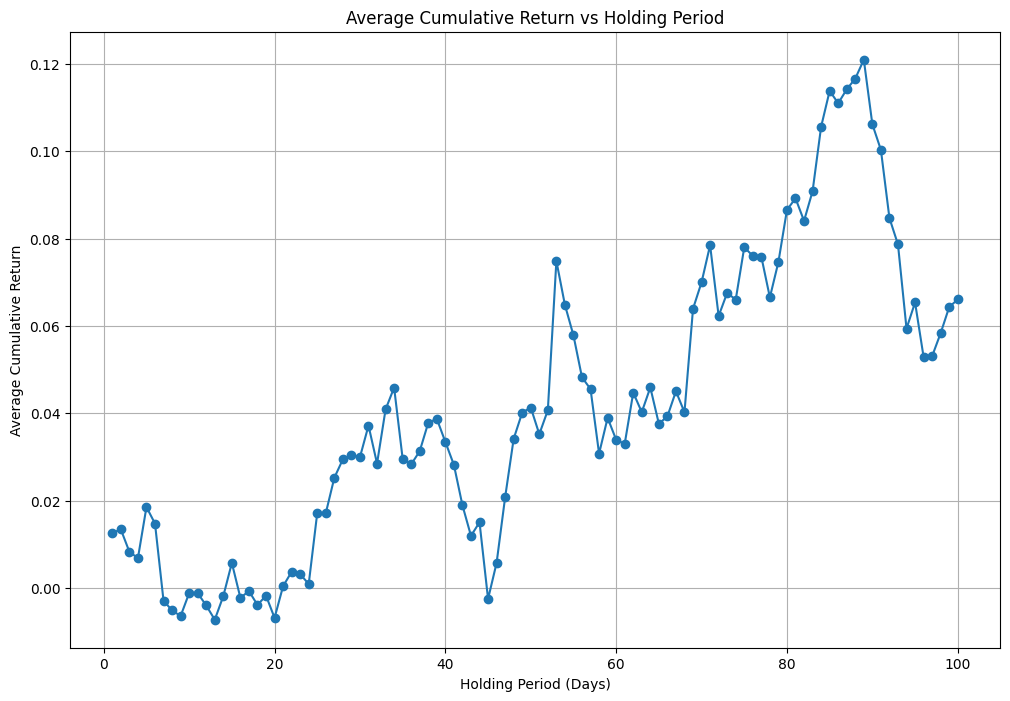

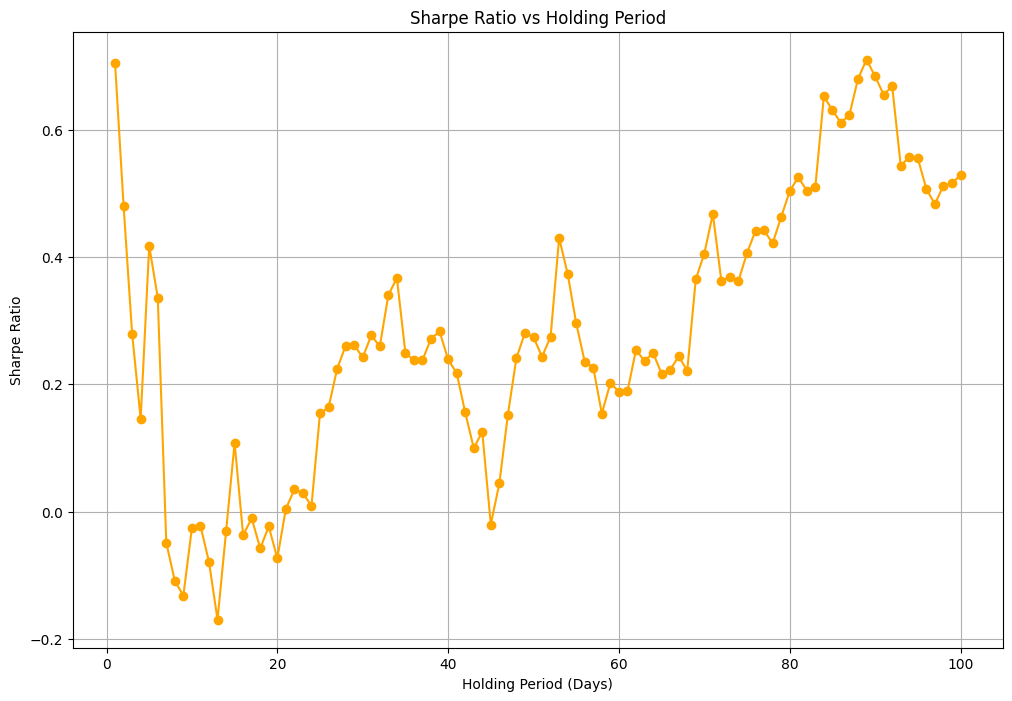

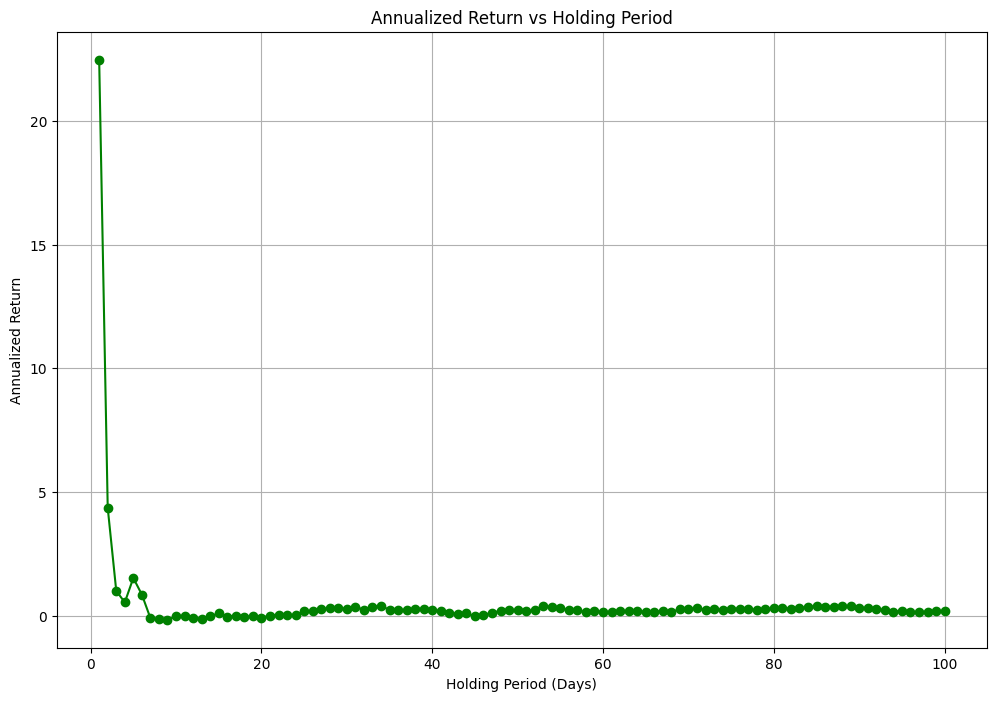

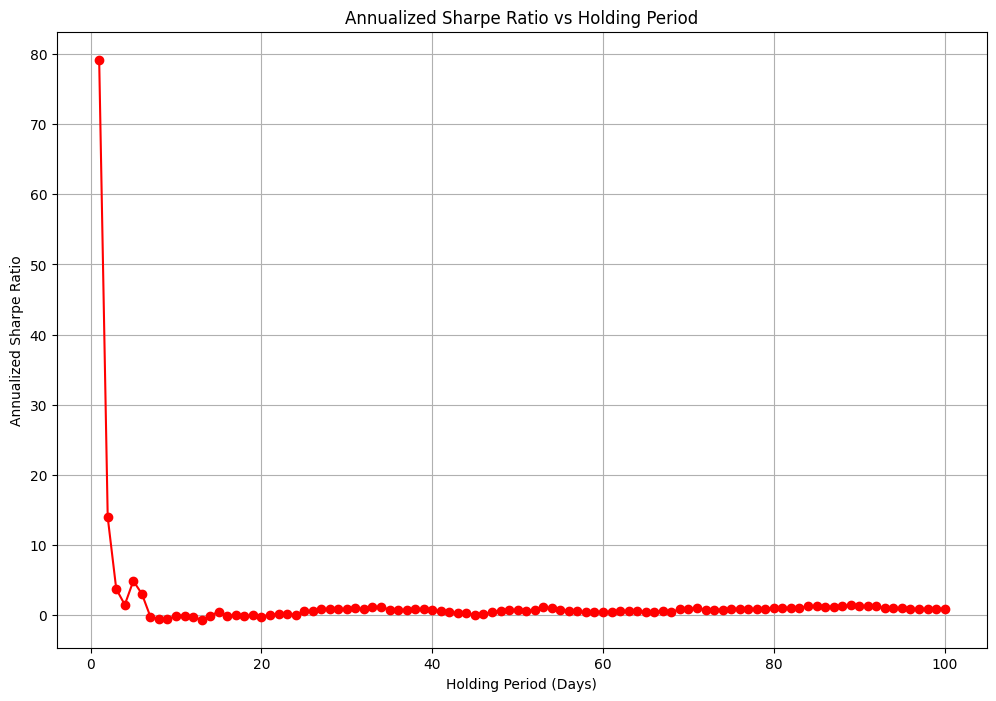

In [57]:

# Combine all data
combined_data = pd.DataFrame()
for ticker, data in aligned_data.items():
    data['Ticker'] = ticker
    combined_data = pd.concat([combined_data, data], axis=0)

# Simulate trades for holding periods from 1 to 100 days
holding_periods = range(1, 101)
results_df = simulate_trade(combined_data, holding_periods)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Average Return'], marker='o')
plt.title('Average Cumulative Return vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Average Cumulative Return')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Sharpe Ratio'], marker='o', color='orange')
plt.title('Sharpe Ratio vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Annualized Return'], marker='o', color='green')
plt.title('Annualized Return vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Annualized Sharpe Ratio'], marker='o', color='red')
plt.title('Annualized Sharpe Ratio vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Annualized Sharpe Ratio')
plt.grid(True)
plt.show()




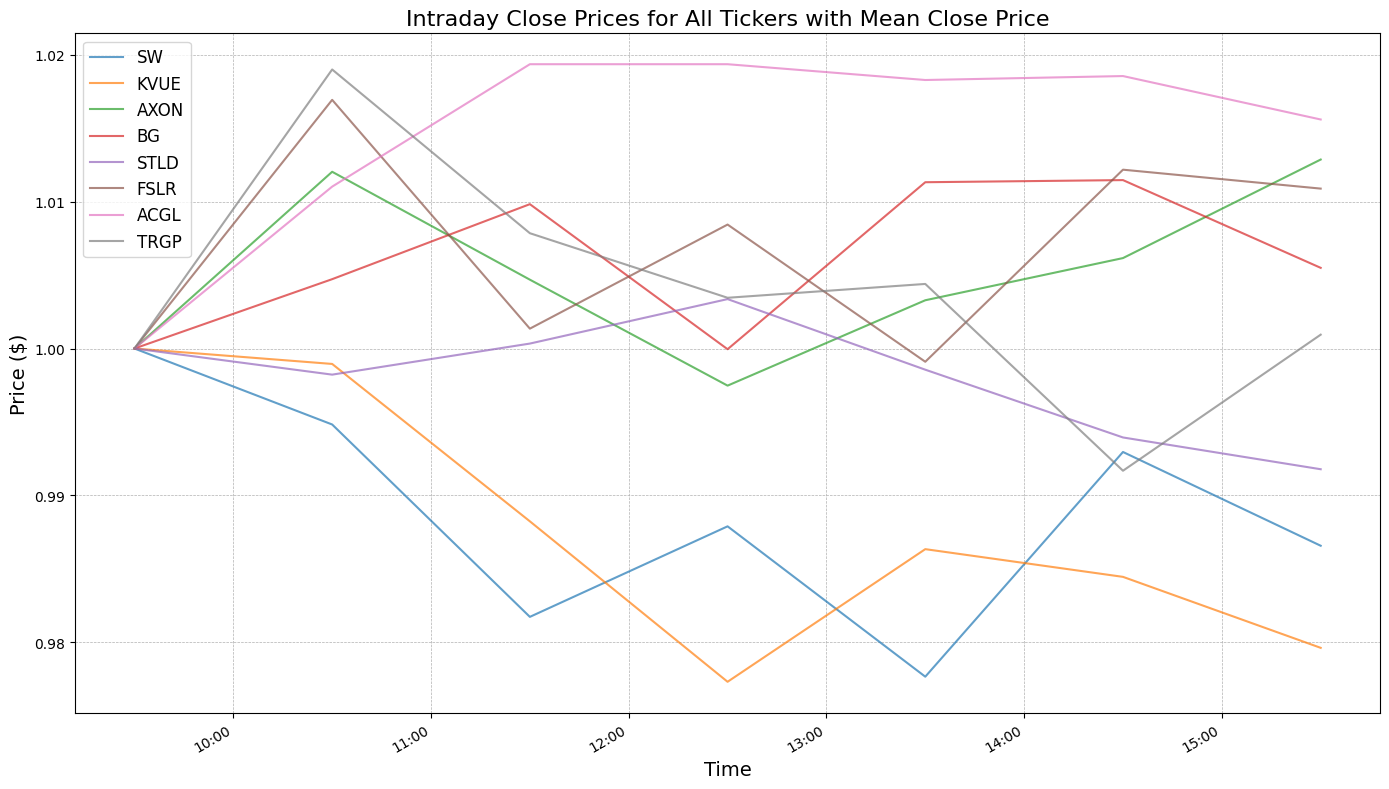

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_all_intraday_close_with_mean(aligned_data_intraday):
    """
    Plots intraday close prices for all tickers on a unified time axis,
    treating data from different days as if they occurred on the same day.
    Also plots the mean close price across all tickers.

    Parameters:
    - aligned_data_intraday (dict): Dictionary where keys are ticker symbols and
      values are pandas DataFrames containing intraday data with at least
      'Datetime' and 'Close' columns.
    """
    valid_tickers = {}
    
    # Validate and filter data first
    for ticker, df in aligned_data_intraday.items():
        if df.empty:
            print(f"No intraday data for {ticker}. Skipping.")
            continue
        
        if 'Datetime' not in df.columns or 'Close' not in df.columns:
            print(f"Required columns ('Datetime' and 'Close') missing for {ticker}. Skipping.")
            continue
        
        # If both 'Datetime' and 'Close' are present, add to valid tickers
        valid_tickers[ticker] = df
    
    if not valid_tickers:
        print("No valid data available to plot after filtering.")
        return

    plt.figure(figsize=(14, 8))
    close_prices = pd.DataFrame()
    
    # Define a common date to assign to all times for consistent plotting
    common_date = pd.Timestamp('1900-01-01')
    
    for ticker, df in valid_tickers.items():
        try:
            # Convert 'Datetime' to datetime objects
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            # Extract time component and assign a common date
            df['Time'] = common_date + pd.to_timedelta(df['Datetime'].dt.time.astype(str))
            # Sort by 'Time' to ensure chronological order
            df = df.sort_values('Time')
        except Exception as e:
            print(f"Error processing 'Datetime' for {ticker}: {e}")
            continue
        
        # Add 'Close' prices to the DataFrame, indexed by 'Time'
        close_prices[ticker] = df.set_index('Time')['Close']
        # Plot 'Close' vs 'Time' for the current ticker
        plt.plot(df['Time'], df['Close']/df['Close'][0], label=ticker, alpha=0.7)
    
    if close_prices.empty:
        print("No data available to plot.")
        return
    
    # Calculate mean close price across tickers for each time point
    mean_close = close_prices.mean(axis=1)
    
    
    # Set plot title and labels
    plt.title('Intraday Close Prices for All Tickers with Mean Close Price', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Price ($)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Format x-axis to display time properly
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability
    
    plt.tight_layout()
    plt.show()



plot_all_intraday_close_with_mean(aligned_data_intraday)


In [59]:
aligned_data_intraday

{'SW':                    Datetime       Open       High        Low      Close  \
 0 2024-07-09 09:30:00-04:00  44.759998  45.810001  44.740002  45.439999   
 1 2024-07-09 10:30:00-04:00  45.430000  45.520000  45.110001  45.205002   
 2 2024-07-09 11:30:00-04:00  45.189999  45.299999  44.529999  44.610001   
 3 2024-07-09 12:30:00-04:00  44.590000  45.080002  44.560001  44.889999   
 4 2024-07-09 13:30:00-04:00  44.884998  44.950001  44.320000  44.424999   
 5 2024-07-09 14:30:00-04:00  44.424999  45.139999  44.419998  45.119999   
 6 2024-07-09 15:30:00-04:00  45.130001  46.690000  44.750000  44.830000   
 
    Adj Close   Volume Ticker                Time  
 0  45.439999        0     SW 1900-01-01 09:30:00  
 1  45.205002  1123016     SW 1900-01-01 10:30:00  
 2  44.610001  1342333     SW 1900-01-01 11:30:00  
 3  44.889999   785911     SW 1900-01-01 12:30:00  
 4  44.424999   657147     SW 1900-01-01 13:30:00  
 5  45.119999   946293     SW 1900-01-01 14:30:00  
 6  44.830000  12602

In [60]:
from scipy import stats

def perform_t_test(returns):
    t_stat, p_value = stats.ttest_1samp(returns, 0)
    # Since we're testing if the mean > 0, adjust p-value for one-tailed test
    p_value /= 2
    return t_stat, p_value

# Apply the t-test on average returns for each holding period
t_test_results = []

for holding_period in holding_periods:
    subset = combined_data[combined_data['Days Since Publish'] >= holding_period]
    returns = []
    for ticker in subset['Ticker'].unique():
        ticker_data = subset[subset['Ticker'] == ticker].reset_index(drop=True)
        if len(ticker_data) >= holding_period:
            start_price = ticker_data['Open'].iloc[0]
            end_price = ticker_data['Close'].iloc[holding_period - 1]
            cumulative_return = (end_price - start_price) / start_price
            returns.append(cumulative_return)
    if len(returns) > 0:
        t_stat, p_val = perform_t_test(returns)
        t_test_results.append({
            'Holding Period': holding_period,
            'T-Statistic': t_stat,
            'P-Value': p_val,
            'Mean Return': np.mean(returns)
        })

t_test_df = pd.DataFrame(t_test_results)

# Display holding periods where p-value < 0.05
significant_results = t_test_df[t_test_df['P-Value'] < 0.05]
print("Significant Holding Periods (p < 0.05):")
print(t_test_df)


Significant Holding Periods (p < 0.05):
    Holding Period  T-Statistic   P-Value  Mean Return
0                1     0.412458  0.346171     0.003319
1                2     0.143792  0.444858     0.001912
2                3     0.453415  0.331986     0.004919
3                4    -1.539099  0.083836    -0.018775
4                5    -0.768982  0.233526    -0.013064
..             ...          ...       ...          ...
71              72     1.666770  0.073304     0.082847
72              73     1.443198  0.099535     0.075628
73              74     2.416590  0.068463     0.081447
74              75          NaN       NaN     0.049420
75              76          NaN       NaN     0.063778

[76 rows x 4 columns]


c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Individual Ticker Returns:
  Ticker    Return
0     SW  0.001564
1   KVUE -0.018105
2   AXON  0.018053
3     BG  0.036235
4   STLD  0.015248
5   FSLR  0.026620
6   ACGL  0.026812
7   TRGP -0.009629

Aggregated Metrics:
Average Return: 0.0121 (1.21%)
Standard Deviation: 0.0191 (1.91%)
Sharpe Ratio: 0.6339
T-Statistic: 1.7928719380932692
P-Value: 0.0580
Number of Tickers: 8


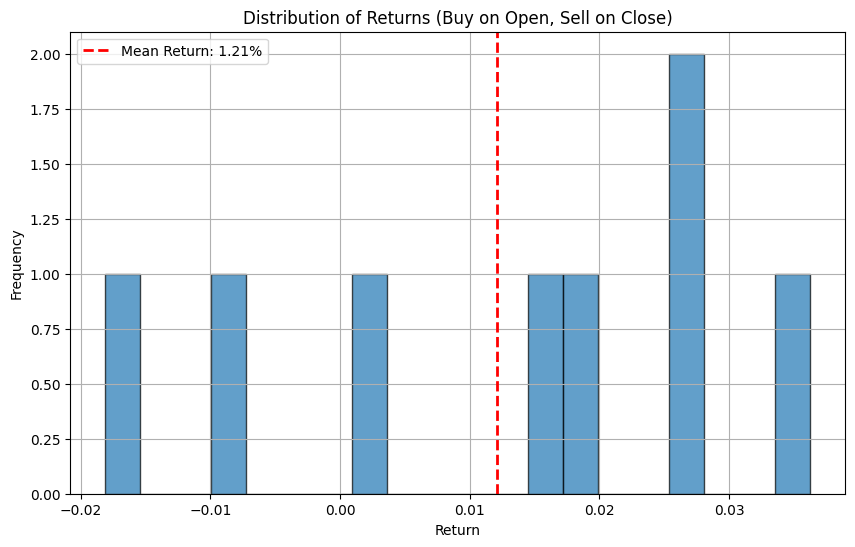

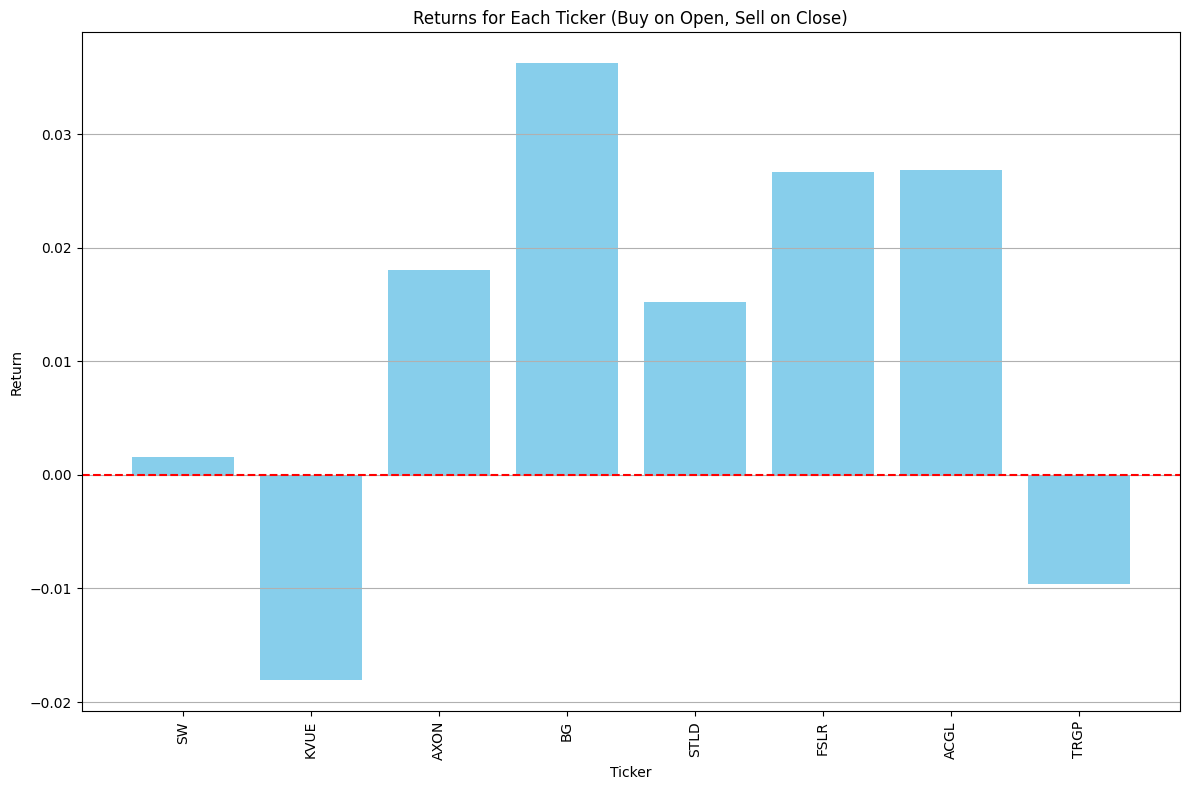


The strategy is not statistically significant or does not have a positive average return (p >= 0.05). Further analysis or strategy adjustment is needed.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def analyze_buy_open_sell_close(aligned_data_intraday):
    """
    Analyzes the buy-on-open and sell-on-close strategy based on intraday data.
    
    Parameters:
    - aligned_data_intraday (dict): Dictionary where keys are ticker symbols and
      values are pandas DataFrames containing intraday data with at least
      'Datetime', 'Open', and 'Close' columns for the publish date.
    
    Returns:
    - analysis_df (DataFrame): DataFrame containing the return for each ticker.
    - metrics (dict): Dictionary containing aggregated metrics.
    """
    returns = []
    tickers = []
    
    for ticker, df in aligned_data_intraday.items():
        if df.empty:
            print(f"No intraday data for {ticker}. Skipping.")
            continue
        
        # Ensure required columns are present
        if not {'Open', 'Close'}.issubset(df.columns):
            print(f"Missing 'Open' or 'Close' columns for {ticker}. Skipping.")
            continue
        
        # Buy at the first 'Open' price and sell at the last 'Close' price
        buy_price = df['Open'].iloc[0]
        sell_price = df['Close'].iloc[-1]
        
        # Calculate return
        cumulative_return = (sell_price - buy_price) / buy_price
        returns.append(cumulative_return)
        tickers.append(ticker)
    
    # Create a DataFrame of returns
    analysis_df = pd.DataFrame({
        'Ticker': tickers,
        'Return': returns
    })
    
    # Calculate metrics
    avg_return = analysis_df['Return'].mean()
    std_deviation = analysis_df['Return'].std(ddof=1)
    sharpe_ratio = calculate_sharpe_ratio(analysis_df['Return'])
    t_stat, p_value = perform_t_test(analysis_df['Return'])
    
    metrics = {
        'Average Return': avg_return,
        'Standard Deviation': std_deviation,
        'Sharpe Ratio': sharpe_ratio,
        'T-Statistic': t_stat,
        'P-Value': p_value,
        'Number of Tickers': len(analysis_df)
    }
    
    return analysis_df, metrics

def calculate_sharpe_ratio(returns, risk_free_rate=0):
    """
    Calculates the Sharpe Ratio for a series of returns.
    
    Parameters:
    - returns (Series or array): Array of returns.
    - risk_free_rate (float): Risk-free rate, default is 0.
    
    Returns:
    - sharpe_ratio (float): Calculated Sharpe Ratio.
    """
    excess_returns = returns - risk_free_rate
    std_return = np.std(excess_returns, ddof=1)
    if std_return != 0:
        return np.mean(excess_returns) / std_return
    else:
        return np.nan

def perform_t_test(returns):
    """
    Performs a one-sample t-test to determine if the mean return is greater than zero.
    
    Parameters:
    - returns (Series or array): Array of returns.
    
    Returns:
    - t_stat (float): T-statistic.
    - p_value (float): One-tailed p-value.
    """
    t_stat, p_value = stats.ttest_1samp(returns, 0)
    # Adjust p-value for one-tailed test (mean > 0)
    p_value /= 2
    if t_stat < 0:
        p_value = 1 - p_value  # If t_stat is negative, p-value should be > 0.5
    return t_stat, p_value

# Analyze the buy-on-open and sell-on-close strategy
analysis_df, metrics = analyze_buy_open_sell_close(aligned_data_intraday)

# Display individual ticker returns
print("Individual Ticker Returns:")
print(analysis_df)

# Display aggregated metrics
print("\nAggregated Metrics:")
for key, value in metrics.items():
    if key == 'Average Return' or key == 'Standard Deviation':
        print(f"{key}: {value:.4f} ({value*100:.2f}%)")
    elif key == 'Sharpe Ratio':
        print(f"{key}: {value:.4f}")
    elif key == 'P-Value':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Visualize the distribution of returns
plt.figure(figsize=(10, 6))
plt.hist(analysis_df['Return'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Returns (Buy on Open, Sell on Close)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.axvline(metrics['Average Return'], color='red', linestyle='dashed', linewidth=2, label=f"Mean Return: {metrics['Average Return']:.2%}")
plt.legend()
plt.grid(True)
plt.show()

# Plot individual returns
plt.figure(figsize=(12, 8))
plt.bar(analysis_df['Ticker'], analysis_df['Return'], color='skyblue')
plt.title('Returns for Each Ticker (Buy on Open, Sell on Close)')
plt.xlabel('Ticker')
plt.ylabel('Return')
plt.xticks(rotation=90)
plt.axhline(0, color='red', linestyle='--')
plt.grid(axis='y')
plt.tight_layout()
plt.show( )

# Print significance of the strategy
if metrics['P-Value'] < 0.05 and metrics['Average Return'] > 0:
    print("\nThe strategy is statistically significant with a positive average return (p < 0.05). Consider pursuing this strategy.")
else:
    print("\nThe strategy is not statistically significant or does not have a positive average return (p >= 0.05). Further analysis or strategy adjustment is needed.")

# Optionally, save the results to a CSV file
# analysis_df.to_csv('buy_open_sell_close_returns.csv', index=False)
# print("\nIndividual ticker returns have been saved to 'buy_open_sell_close_returns.csv'.")


In [62]:
# Extract holding period = 1 returns from the first analysis
holding_period_1_returns = results_df[results_df['Holding Period'] == 1]['Average Return']
print("Holding Period 1 Returns (First Analysis):", holding_period_1_returns.mean())
# Extract returns from the second analysis
print("Buy on Open, Sell on Close Average Return (Second Analysis):", metrics['Average Return'])


Holding Period 1 Returns (First Analysis): 0.01260316055571761
Buy on Open, Sell on Close Average Return (Second Analysis): 0.01209988564192578


[*********************100%%**********************]  1 of 1 completed


Successfully downloaded and aligned data for SW
Successfully downloaded intraday data for SW on 2024-07-08


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SW240920C00045000']: Exception("%ticker%: Data doesn't exist for startDate = 1720497600, endDate = 1720584000")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CRWD']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No historical data found for option SW240920C00045000 on 2024-07-09.
No option data for SW240920C00045000 on 2024-07-08
Successfully downloaded and aligned data for CRWD
Error fetching intraday data for CRWD on 2024-06-07: No intraday data found for CRWD on 2024-06-07
No intraday data for CRWD on 2024-06-07


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CRWD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2024-06-08 00:00:00 -> 2024-06-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['KKR']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No stock data found for CRWD on 2024-06-08.
Could not determine ATM call option for CRWD on 2024-06-07
Successfully downloaded and aligned data for KKR
Error fetching intraday data for KKR on 2024-06-07: No intraday data found for KKR on 2024-06-07
No intraday data for KKR on 2024-06-07


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['KKR']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2024-06-08 00:00:00 -> 2024-06-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GDDY']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No stock data found for KKR on 2024-06-08.
Could not determine ATM call option for KKR on 2024-06-07
Successfully downloaded and aligned data for GDDY
Error fetching intraday data for GDDY on 2024-06-07: No intraday data found for GDDY on 2024-06-07
No intraday data for GDDY on 2024-06-07


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GDDY']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2024-06-08 00:00:00 -> 2024-06-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['VST']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No stock data found for GDDY on 2024-06-08.
Could not determine ATM call option for GDDY on 2024-06-07
Successfully downloaded and aligned data for VST
Error fetching intraday data for VST on 2024-05-03: No intraday data found for VST on 2024-05-03
No intraday data for VST on 2024-05-03


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['VST']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2024-05-04 00:00:00 -> 2024-05-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for VST on 2024-05-04.
Could not determine ATM call option for VST on 2024-05-03
Successfully downloaded and aligned data for GEV



1 Failed download:
['GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1711632600, endDate = 1711659600")


Error fetching intraday data for GEV on 2024-03-27: No intraday data found for GEV on 2024-03-27
No intraday data for GEV on 2024-03-27


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1711598400, endDate = 1711684800")
[*********************100%%**********************]  1 of 1 completed


No stock data found for GEV on 2024-03-28.
Could not determine ATM call option for GEV on 2024-03-27
Successfully downloaded and aligned data for SOLV



1 Failed download:
['SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1711632600, endDate = 1711659600")


Error fetching intraday data for SOLV on 2024-03-27: No intraday data found for SOLV on 2024-03-27
No intraday data for SOLV on 2024-03-27


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1711598400, endDate = 1711684800")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DECK']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No stock data found for SOLV on 2024-03-28.
Could not determine ATM call option for SOLV on 2024-03-27
Successfully downloaded and aligned data for DECK
Error fetching intraday data for DECK on 2024-03-01: No intraday data found for DECK on 2024-03-01
No intraday data for DECK on 2024-03-01


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DECK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2024-03-02 00:00:00 -> 2024-03-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SMCI']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No stock data found for DECK on 2024-03-02.
Could not determine ATM call option for DECK on 2024-03-01
Successfully downloaded and aligned data for SMCI
Error fetching intraday data for SMCI on 2024-03-01: No intraday data found for SMCI on 2024-03-01
No intraday data for SMCI on 2024-03-01


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SMCI']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2024-03-02 00:00:00 -> 2024-03-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BLDR']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No stock data found for SMCI on 2024-03-02.
Could not determine ATM call option for SMCI on 2024-03-01
Successfully downloaded and aligned data for BLDR
Error fetching intraday data for BLDR on 2023-12-01: No intraday data found for BLDR on 2023-12-01
No intraday data for BLDR on 2023-12-01


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BLDR']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-12-02 00:00:00 -> 2023-12-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['UBER']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No stock data found for BLDR on 2023-12-02.
Could not determine ATM call option for BLDR on 2023-12-01
Successfully downloaded and aligned data for UBER
Error fetching intraday data for UBER on 2023-12-01: No intraday data found for UBER on 2023-12-01
No intraday data for UBER on 2023-12-01


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['UBER']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-12-02 00:00:00 -> 2023-12-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:


No stock data found for UBER on 2023-12-02.
Could not determine ATM call option for UBER on 2023-12-01
Successfully downloaded and aligned data for JBL


['JBL']: IndexError('index 0 is out of bounds for axis 0 with size 0')


Error fetching intraday data for JBL on 2023-12-01: No intraday data found for JBL on 2023-12-01
No intraday data for JBL on 2023-12-01


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['JBL']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-12-02 00:00:00 -> 2023-12-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for JBL on 2023-12-02.
Could not determine ATM call option for JBL on 2023-12-01
Successfully downloaded and aligned data for LULU



1 Failed download:
['LULU']: IndexError('index 0 is out of bounds for axis 0 with size 0')


Error fetching intraday data for LULU on 2023-10-13: No intraday data found for LULU on 2023-10-13
No intraday data for LULU on 2023-10-13


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['LULU']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-10-14 00:00:00 -> 2023-10-15 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['HUBB']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No stock data found for LULU on 2023-10-14.
Could not determine ATM call option for LULU on 2023-10-13
Successfully downloaded and aligned data for HUBB
Error fetching intraday data for HUBB on 2023-10-13: No intraday data found for HUBB on 2023-10-13
No intraday data for HUBB on 2023-10-13


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['HUBB']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-10-14 00:00:00 -> 2023-10-15 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for HUBB on 2023-10-14.
Could not determine ATM call option for HUBB on 2023-10-13
Successfully downloaded and aligned data for VLTO



1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1695994200, endDate = 1696021200")


Error fetching intraday data for VLTO on 2023-09-28: No intraday data found for VLTO on 2023-09-28
No intraday data for VLTO on 2023-09-28


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1695960000, endDate = 1696046400")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ABNB']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No stock data found for VLTO on 2023-09-29.
Could not determine ATM call option for VLTO on 2023-09-28
Successfully downloaded and aligned data for ABNB
Error fetching intraday data for ABNB on 2023-09-01: No intraday data found for ABNB on 2023-09-01
No intraday data for ABNB on 2023-09-01


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ABNB']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-09-02 00:00:00 -> 2023-09-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:


No stock data found for ABNB on 2023-09-02.
Could not determine ATM call option for ABNB on 2023-09-01
Successfully downloaded and aligned data for BX


['BX']: IndexError('index 0 is out of bounds for axis 0 with size 0')


Error fetching intraday data for BX on 2023-09-01: No intraday data found for BX on 2023-09-01
No intraday data for BX on 2023-09-01


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-09-02 00:00:00 -> 2023-09-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for BX on 2023-09-02.
Could not determine ATM call option for BX on 2023-09-01
Successfully downloaded and aligned data for KVUE
Successfully downloaded intraday data for KVUE on 2023-08-09


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['KVUE240920C00023500']: Exception("%ticker%: Data doesn't exist for startDate = 1691640000, endDate = 1691726400")
[*********************100%%**********************]  1 of 1 completed


No historical data found for option KVUE240920C00023500 on 2023-08-10.
No option data for KVUE240920C00023500 on 2023-08-09
Successfully downloaded and aligned data for PANW



1 Failed download:
['PANW']: IndexError('index 0 is out of bounds for axis 0 with size 0')


Error fetching intraday data for PANW on 2023-06-02: No intraday data found for PANW on 2023-06-02
No intraday data for PANW on 2023-06-02


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PANW']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-06-03 00:00:00 -> 2023-06-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for PANW on 2023-06-03.
Could not determine ATM call option for PANW on 2023-06-02
Successfully downloaded and aligned data for AXON
Successfully downloaded intraday data for AXON on 2023-05-01


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['AXON240920C00220000']: Exception("%ticker%: Data doesn't exist for startDate = 1683000000, endDate = 1683086400")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:


No historical data found for option AXON240920C00220000 on 2023-05-02.
No option data for AXON240920C00220000 on 2023-05-01
Successfully downloaded and aligned data for FICO


['FICO']: IndexError('index 0 is out of bounds for axis 0 with size 0')


Error fetching intraday data for FICO on 2023-03-03: No intraday data found for FICO on 2023-03-03
No intraday data for FICO on 2023-03-03


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FICO']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-03-04 00:00:00 -> 2023-03-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for FICO on 2023-03-04.
Could not determine ATM call option for FICO on 2023-03-03
Successfully downloaded and aligned data for BG
Successfully downloaded intraday data for BG on 2023-03-13


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BG240920C00105000']: Exception("%ticker%: Data doesn't exist for startDate = 1678766400, endDate = 1678852800")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PODD']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No historical data found for option BG240920C00105000 on 2023-03-14.
No option data for BG240920C00105000 on 2023-03-13
Successfully downloaded and aligned data for PODD
Error fetching intraday data for PODD on 2023-03-10: No intraday data found for PODD on 2023-03-10
No intraday data for PODD on 2023-03-10


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PODD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-03-11 00:00:00 -> 2023-03-12 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GEHC']: IndexError('index 0 is out of bounds for axis 0 with size 0')


No stock data found for PODD on 2023-03-11.
Could not determine ATM call option for PODD on 2023-03-10
Successfully downloaded and aligned data for GEHC
Error fetching intraday data for GEHC on 2022-12-28: No intraday data found for GEHC on 2022-12-28
No intraday data for GEHC on 2022-12-28


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GEHC240920C00060000']: Exception("%ticker%: Data doesn't exist for startDate = 1672290000, endDate = 1672376400")
[*********************100%%**********************]  1 of 1 completed


No historical data found for option GEHC240920C00060000 on 2022-12-29.
No option data for GEHC240920C00060000 on 2022-12-28
Successfully downloaded and aligned data for STLD
Successfully downloaded intraday data for STLD on 2022-12-19


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['STLD240920C00105000']: Exception("%ticker%: Data doesn't exist for startDate = 1671512400, endDate = 1671598800")
[*********************100%%**********************]  1 of 1 completed


No historical data found for option STLD240920C00105000 on 2022-12-20.
No option data for STLD240920C00105000 on 2022-12-19
Successfully downloaded and aligned data for FSLR
Successfully downloaded intraday data for FSLR on 2022-12-12


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FSLR240920C00155000']: Exception("%ticker%: Data doesn't exist for startDate = 1670907600, endDate = 1670994000")
[*********************100%%**********************]  1 of 1 completed


No historical data found for option FSLR240920C00155000 on 2022-12-13.
No option data for FSLR240920C00155000 on 2022-12-12
Successfully downloaded and aligned data for ACGL
Successfully downloaded intraday data for ACGL on 2022-10-27


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ACGL240920C00055000']: Exception("%ticker%: Data doesn't exist for startDate = 1666929600, endDate = 1667016000")
[*********************100%%**********************]  1 of 1 completed


No historical data found for option ACGL240920C00055000 on 2022-10-28.
No option data for ACGL240920C00055000 on 2022-10-27
Successfully downloaded and aligned data for TRGP
Successfully downloaded intraday data for TRGP on 2022-10-06


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TRGP240920C00125000']: Exception("%ticker%: Data doesn't exist for startDate = 1665115200, endDate = 1665201600")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:


No historical data found for option TRGP240920C00125000 on 2022-10-07.
No option data for TRGP240920C00125000 on 2022-10-06
Successfully downloaded and aligned data for EQT


['EQT']: IndexError('index 0 is out of bounds for axis 0 with size 0')


Error fetching intraday data for EQT on 2022-09-23: No intraday data found for EQT on 2022-09-23
No intraday data for EQT on 2022-09-23


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['EQT']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-09-24 00:00:00 -> 2022-09-25 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:


No stock data found for EQT on 2022-09-24.
Could not determine ATM call option for EQT on 2022-09-23
Successfully downloaded and aligned data for PCG


['PCG']: IndexError('index 0 is out of bounds for axis 0 with size 0')


Error fetching intraday data for PCG on 2022-09-23: No intraday data found for PCG on 2022-09-23
No intraday data for PCG on 2022-09-23


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PCG']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-09-24 00:00:00 -> 2022-09-25 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for PCG on 2022-09-24.
Could not determine ATM call option for PCG on 2022-09-23
Successfully downloaded and aligned data for CSGP



1 Failed download:
['CSGP']: Exception('%ticker%: 1h data not available for startTime=1662211800 and endTime=1662238800. The requested range must be within the last 730 days.')


Error fetching intraday data for CSGP on 2022-09-02: No intraday data found for CSGP on 2022-09-02
No intraday data for CSGP on 2022-09-02


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CSGP']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-09-03 00:00:00 -> 2022-09-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for CSGP on 2022-09-03.
Could not determine ATM call option for CSGP on 2022-09-02
Successfully downloaded and aligned data for INVH



1 Failed download:
['INVH']: Exception('%ticker%: 1h data not available for startTime=1662211800 and endTime=1662238800. The requested range must be within the last 730 days.')


Error fetching intraday data for INVH on 2022-09-02: No intraday data found for INVH on 2022-09-02
No intraday data for INVH on 2022-09-02


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['INVH']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-09-03 00:00:00 -> 2022-09-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for INVH on 2022-09-03.
Could not determine ATM call option for INVH on 2022-09-02
Successfully downloaded and aligned data for KDP



1 Failed download:
['KDP']: Exception('%ticker%: 1h data not available for startTime=1654349400 and endTime=1654376400. The requested range must be within the last 730 days.')


Error fetching intraday data for KDP on 2022-06-03: No intraday data found for KDP on 2022-06-03
No intraday data for KDP on 2022-06-03


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['KDP']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-04 00:00:00 -> 2022-06-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for KDP on 2022-06-04.
Could not determine ATM call option for KDP on 2022-06-03
Successfully downloaded and aligned data for ON



1 Failed download:
['ON']: Exception('%ticker%: 1h data not available for startTime=1654349400 and endTime=1654376400. The requested range must be within the last 730 days.')


Error fetching intraday data for ON on 2022-06-03: No intraday data found for ON on 2022-06-03
No intraday data for ON on 2022-06-03


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ON']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-04 00:00:00 -> 2022-06-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


No stock data found for ON on 2022-06-04.
Could not determine ATM call option for ON on 2022-06-03
Successfully downloaded and aligned data for VICI



1 Failed download:
['VICI']: Exception('%ticker%: 1h data not available for startTime=1654349400 and endTime=1654376400. The requested range must be within the last 730 days.')


Error fetching intraday data for VICI on 2022-06-03: No intraday data found for VICI on 2022-06-03
No intraday data for VICI on 2022-06-03


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['VICI']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-04 00:00:00 -> 2022-06-05 00:00:00)')


No stock data found for VICI on 2022-06-04.
Could not determine ATM call option for VICI on 2022-06-03


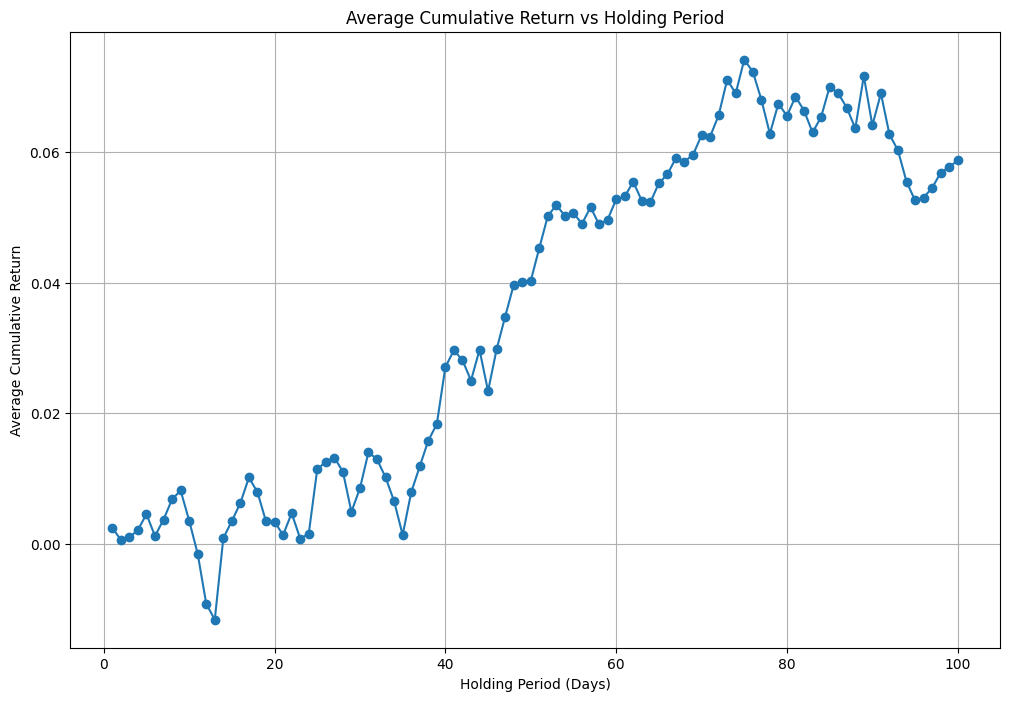

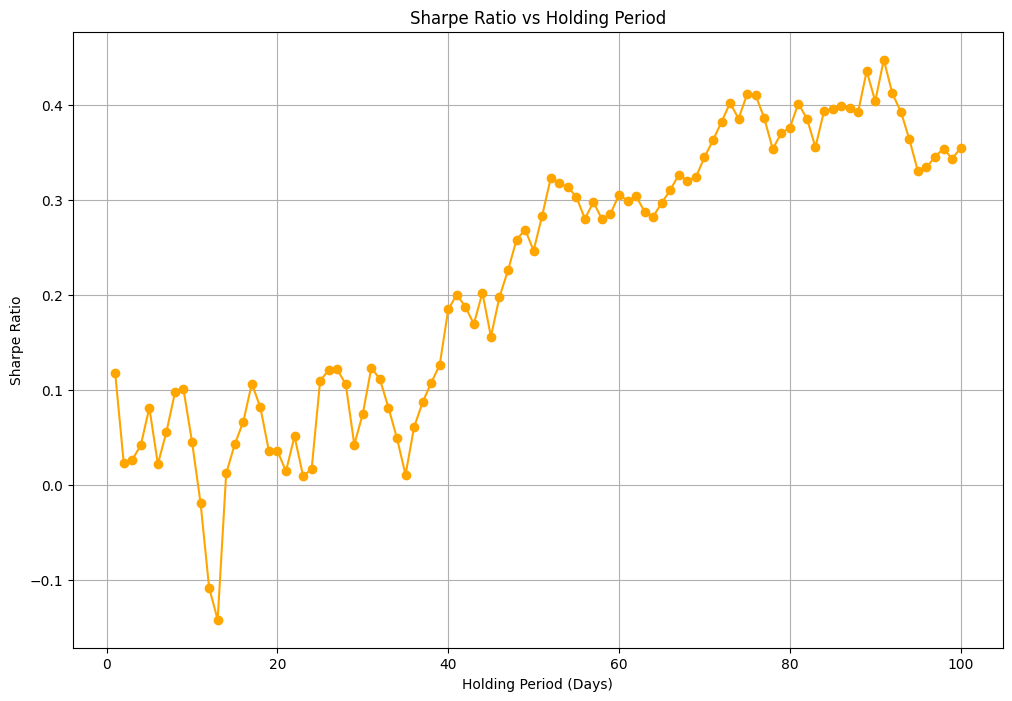

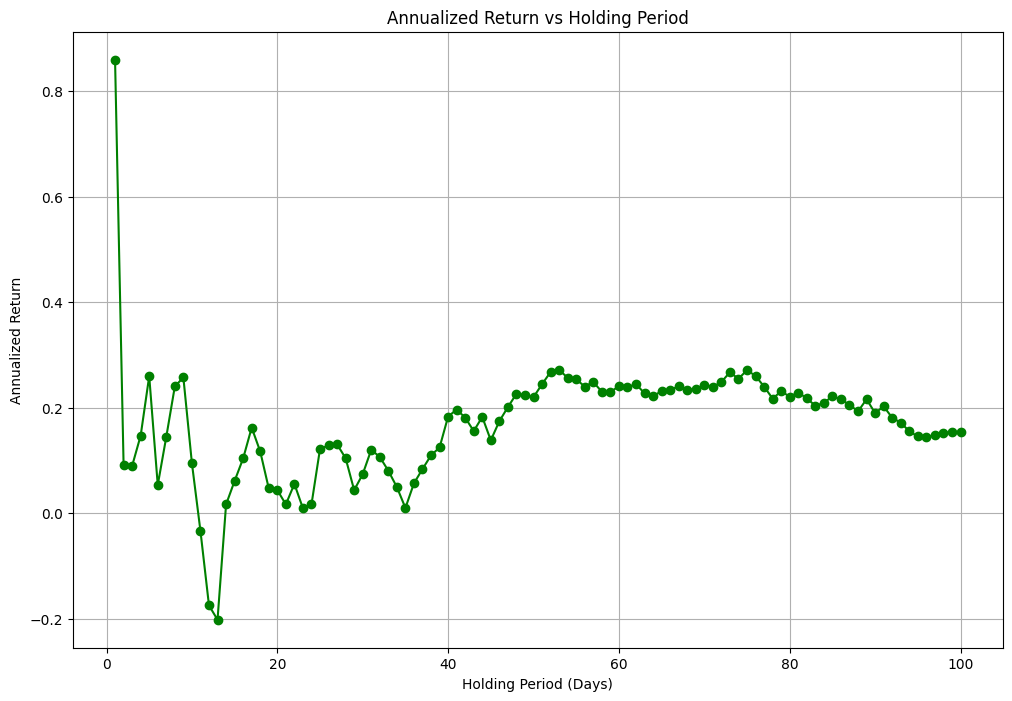

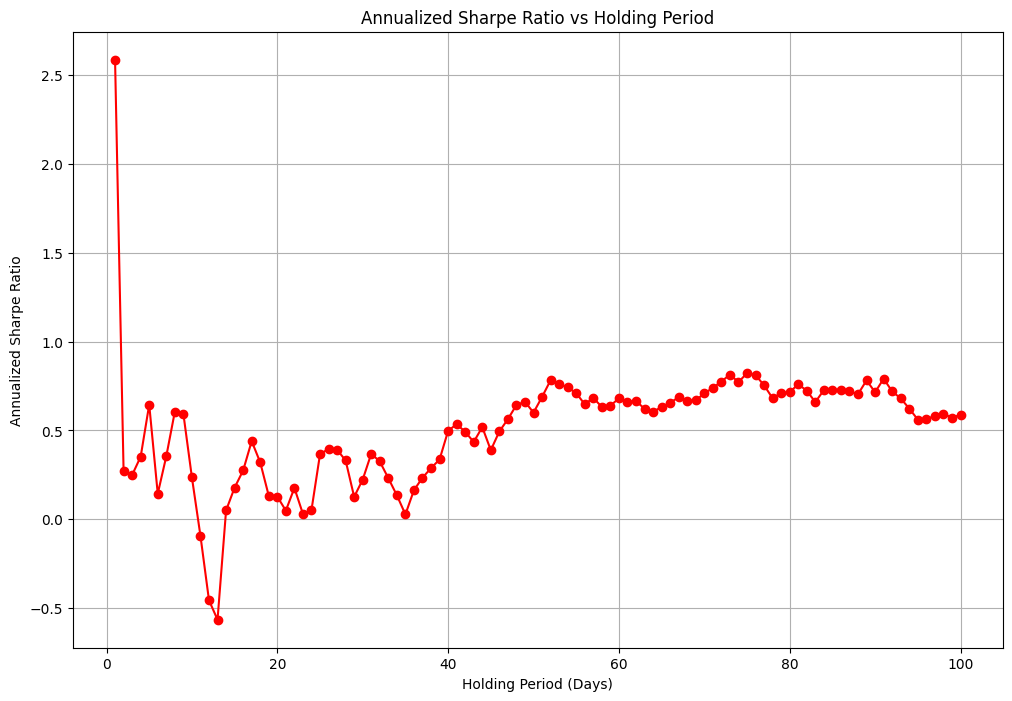

C:\Users\takat\AppData\Local\Temp\ipykernel_21704\3148160923.py:352: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(close_prices.index.strftime('%H:%M')))


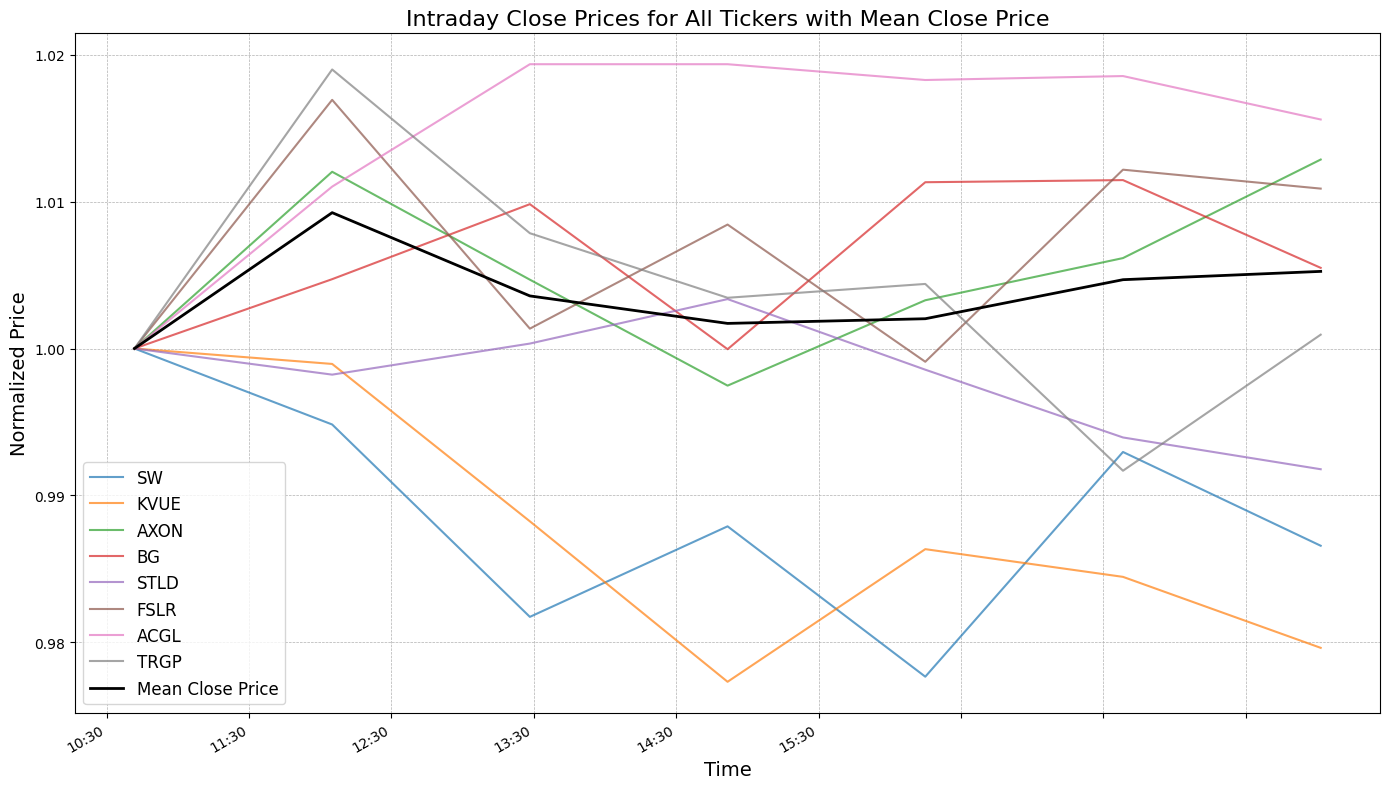

c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Significant Holding Periods (p < 0.05):
    Holding Period  T-Statistic   P-Value  Mean Return
0                1     0.943534  0.176032     0.003316
1                2    -0.017144  0.493211    -0.000122
2                3    -0.168533  0.433581    -0.001145
3                4     0.416012  0.340008     0.003927
4                5    -0.304752  0.381206    -0.003297
..             ...          ...       ...          ...
71              72    -0.379229  0.354077    -0.014525
72              73    -0.319034  0.376505    -0.015754
73              74     1.527767  0.085206     0.087758
74              75          NaN       NaN     0.049420
75              76          NaN       NaN     0.063778

[76 rows x 4 columns]


In [64]:
import yfinance as yf
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats

# Load companies data
with open('companies.json', 'r') as file:
    companies = json.load(file)

def calculate_sharpe_ratio(returns, risk_free_rate=0):
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    if std_return != 0:
        return (mean_return - risk_free_rate) / std_return
    else:
        return np.nan

def annualize_return(cumulative_return, holding_period_days, periods_per_year=252):
    return (1 + cumulative_return) ** (periods_per_year / holding_period_days) - 1

def annualize_std(cumulative_std, holding_period_days, periods_per_year=252):
    return cumulative_std * np.sqrt(periods_per_year / holding_period_days)

def annualize_sharpe(annualized_return, annualized_std):
    if annualized_std != 0:
        return annualized_return / annualized_std
    else:
        return np.nan

def download_and_align_data(ticker, publish_date):
    publish_date = pd.to_datetime(publish_date)
    start_date = publish_date + pd.DateOffset(1)
    end_date = publish_date + pd.DateOffset(months=6)  # Increased to 6 months to cover longer holding periods
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    if 'Close' not in stock_data.columns or 'Open' not in stock_data.columns:
        raise ValueError(f"Data for {ticker} does not contain 'Close' or 'Open' prices.")
    stock_data = stock_data.reset_index()
    stock_data['Days Since Publish'] = (stock_data['Date'] - stock_data['Date'].iloc[0]).dt.days
    stock_data['Ticker'] = ticker
    return stock_data[['Date', 'Days Since Publish', 'Open', 'Close', 'Ticker']]

def simulate_trade(data, holding_periods):
    tickers = data['Ticker'].unique()
    results = []

    for holding_period in holding_periods:
        returns = []
        for ticker in tickers:
            ticker_data = data[data['Ticker'] == ticker].reset_index(drop=True)
            if len(ticker_data) >= holding_period:
                start_price = ticker_data['Open'].iloc[0]
                end_price = ticker_data['Close'].iloc[holding_period - 1]
                cumulative_return = (end_price - start_price) / start_price
                returns.append(cumulative_return)
        if len(returns) > 0:
            avg_return = np.mean(returns)
            std_deviation = np.std(returns)
            sharpe_ratio = calculate_sharpe_ratio(returns)
            annualized_ret = annualize_return(avg_return, holding_period)
            annualized_std_dev = annualize_std(std_deviation, holding_period)
            annualized_sharpe = annualize_sharpe(annualized_ret, annualized_std_dev)
            results.append({
                'Holding Period': holding_period,
                'Average Return': avg_return,
                'Standard Deviation': std_deviation,
                'Sharpe Ratio': sharpe_ratio,
                'Annualized Return': annualized_ret,
                'Annualized Std Dev': annualized_std_dev,
                'Annualized Sharpe Ratio': annualized_sharpe
            })
    return pd.DataFrame(results)

def download_intraday_data(ticker, publish_date, interval='1m'):
    publish_date = pd.to_datetime(publish_date)
    
    # Define the start and end time for the publish date
    # Assuming publish_date is the date when the news is released before market opens or during trading hours
    start_datetime = publish_date + timedelta(days=1, hours=9, minutes=30)
    end_datetime = publish_date + timedelta(days=1, hours=17)
    
    try:
        intraday_data = yf.download(
            ticker,
            start=start_datetime,
            end=end_datetime,
            interval=interval,
            prepost=True,  # Include pre-market and post-market data
            progress=False
        )
        
        if intraday_data.empty:
            raise ValueError(f"No intraday data found for {ticker} on {publish_date.date()}")
        
        # Reset index to have 'Datetime' as a column
        intraday_data = intraday_data.reset_index()
        
        # Add 'Ticker' column for identification
        intraday_data['Ticker'] = ticker
        
        return intraday_data
    except Exception as e:
        print(f"Error fetching intraday data for {ticker} on {publish_date.date()}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on failure

def get_atm_call_option(ticker, publish_date):
    """
    Retrieves the ATM call option symbol for the given ticker on the day after the publish_date.
    
    Parameters:
    - ticker (str): Stock ticker symbol.
    - publish_date (str or datetime): Publish date.
    
    Returns:
    - option_symbol (str): Symbol of the ATM call option.
    - expiration_date (str): Expiration date of the option.
    """
    try:
        stock = yf.Ticker(ticker)
        # Get all available option expiration dates
        expiration_dates = stock.options
        if not expiration_dates:
            print(f"No option expiration dates found for {ticker}.")
            return None, None
        
        # Select the closest expiration date after the publish date +1 day
        publish_date_dt = pd.to_datetime(publish_date) + pd.Timedelta(days=1)
        expiration_date = min([pd.to_datetime(date) for date in expiration_dates if pd.to_datetime(date) >= publish_date_dt], default=None)
        
        if expiration_date is None:
            print(f"No suitable expiration date found for {ticker} after {publish_date}.")
            return None, None
        
        expiration_str = expiration_date.strftime('%Y-%m-%d')
        # Get option chain for the selected expiration date
        option_chain = stock.option_chain(expiration_str)
        calls = option_chain.calls
        
        if calls.empty:
            print(f"No call options found for {ticker} on expiration date {expiration_str}.")
            return None, None
        
        # Get the stock price on the day after publish_date to find ATM strike
        stock_data = yf.download(ticker, start=publish_date_dt, end=publish_date_dt + pd.Timedelta(days=1))
        if stock_data.empty:
            print(f"No stock data found for {ticker} on {publish_date_dt.date()}.")
            return None, None
        stock_price = stock_data['Close'].iloc[0]
        
        # Find the ATM strike (closest to stock price)
        calls['Strike Difference'] = abs(calls['strike'] - stock_price)
        atm_call = calls.loc[calls['Strike Difference'].idxmin()]
        option_symbol = atm_call['contractSymbol']
        
        return option_symbol, expiration_str
    except Exception as e:
        print(f"Error retrieving ATM call option for {ticker} on {publish_date}: {e}")
        return None, None

def download_option_data(option_symbol, publish_date):
    """
    Downloads the historical data for the given option symbol on the publish_date +1 day.
    
    Parameters:
    - option_symbol (str): Option contract symbol.
    - publish_date (str or datetime): Publish date.
    
    Returns:
    - option_data (DataFrame): Historical data for the option.
    """
    try:
        publish_date_dt = pd.to_datetime(publish_date) + pd.Timedelta(days=1)
        start_datetime = publish_date_dt
        end_datetime = publish_date_dt + pd.Timedelta(days=1)
        
        option_data = yf.download(
            option_symbol,
            start=start_datetime,
            end=end_datetime,
            interval='1d',
            progress=False
        )
        
        if option_data.empty:
            print(f"No historical data found for option {option_symbol} on {publish_date_dt.date()}.")
            return None
        
        option_data = option_data.reset_index()
        option_data['Option Symbol'] = option_symbol
        return option_data
    except Exception as e:
        print(f"Error downloading data for option {option_symbol} on {publish_date}: {e}")
        return None

# Initialize dictionaries to store data
aligned_data = {}
aligned_data_intraday = {}
options_data = {}

for company in companies:
    ticker = company['ticker']
    publish_date = company['publish_date']
    try:
        # Download and align stock data
        aligned_data[ticker] = download_and_align_data(ticker, publish_date)
        print(f"Successfully downloaded and aligned data for {ticker}")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
    
    try:
        # Download intraday data
        intraday = download_intraday_data(ticker, publish_date, interval='1h')  # You can change interval if needed
        if not intraday.empty:
            aligned_data_intraday[ticker] = intraday
            print(f"Successfully downloaded intraday data for {ticker} on {publish_date}")
        else:
            print(f"No intraday data for {ticker} on {publish_date}")
    except Exception as e:
        print(f"Error downloading intraday data for {ticker}: {e}")
    
    try:
        # Get ATM call option symbol
        option_symbol, expiration_date = get_atm_call_option(ticker, publish_date)
        if option_symbol:
            # Download option historical data
            option_hist_data = download_option_data(option_symbol, publish_date)
            if option_hist_data is not None:
                options_data[option_symbol] = option_hist_data
                print(f"Successfully downloaded option data for {option_symbol} on {publish_date}")
            else:
                print(f"No option data for {option_symbol} on {publish_date}")
        else:
            print(f"Could not determine ATM call option for {ticker} on {publish_date}")
    except Exception as e:
        print(f"Error processing options for {ticker}: {e}")

# Combine all stock data
combined_data = pd.DataFrame()
for ticker, data in aligned_data.items():
    combined_data = pd.concat([combined_data, data], axis=0)

# Simulate trades for holding periods from 1 to 100 days
holding_periods = range(1, 101)
results_df = simulate_trade(combined_data, holding_periods)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Average Return'], marker='o')
plt.title('Average Cumulative Return vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Average Cumulative Return')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Sharpe Ratio'], marker='o', color='orange')
plt.title('Sharpe Ratio vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Annualized Return'], marker='o', color='green')
plt.title('Annualized Return vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Annualized Sharpe Ratio'], marker='o', color='red')
plt.title('Annualized Sharpe Ratio vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Annualized Sharpe Ratio')
plt.grid(True)
plt.show()

def plot_all_intraday_close_with_mean(aligned_data_intraday):
    """
    Plots intraday close prices for all tickers on a unified time axis,
    treating data from different days as if they occurred on the same day.
    Also plots the mean close price across all tickers.

    Parameters:
    - aligned_data_intraday (dict): Dictionary where keys are ticker symbols and
      values are pandas DataFrames containing intraday data with at least
      'Datetime' and 'Close' columns.
    """
    valid_tickers = {}
    
    # Validate and filter data first
    for ticker, df in aligned_data_intraday.items():
        if df.empty:
            print(f"No intraday data for {ticker}. Skipping.")
            continue
        
        if 'Datetime' not in df.columns or 'Close' not in df.columns:
            print(f"Required columns ('Datetime' and 'Close') missing for {ticker}. Skipping.")
            continue
        
        # If both 'Datetime' and 'Close' are present, add to valid tickers
        valid_tickers[ticker] = df
    
    if not valid_tickers:
        print("No valid data available to plot after filtering.")
        return

    plt.figure(figsize=(14, 8))
    close_prices = pd.DataFrame()
    
    # Define a common date to assign to all times for consistent plotting
    common_date = pd.Timestamp('1900-01-01')
    
    for ticker, df in valid_tickers.items():
        try:
            # Convert 'Datetime' to datetime objects
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            # Extract time component and assign a common date
            df['Time'] = common_date + pd.to_timedelta(df['Datetime'].dt.time.astype(str))
            # Sort by 'Time' to ensure chronological order
            df = df.sort_values('Time')
        except Exception as e:
            print(f"Error processing 'Datetime' for {ticker}: {e}")
            continue
        
        # Add 'Close' prices to the DataFrame, indexed by 'Time'
        close_prices[ticker] = df.set_index('Time')['Close']
        # Plot 'Close' vs 'Time' for the current ticker
        plt.plot(df['Time'], df['Close']/df['Close'][0], label=ticker, alpha=0.7)
    
    if close_prices.empty:
        print("No data available to plot.")
        return
    
    # Calculate mean close price across tickers for each time point
    mean_close = close_prices.mean(axis=1)
    
    # Plot mean close price
    plt.plot(close_prices.index, mean_close/mean_close.iloc[0], label='Mean Close Price', color='black', linewidth=2)
    
    # Set plot title and labels
    plt.title('Intraday Close Prices for All Tickers with Mean Close Price', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Normalized Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Format x-axis to display time properly
    plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(close_prices.index.strftime('%H:%M')))
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability
    
    plt.tight_layout()
    plt.show()

plot_all_intraday_close_with_mean(aligned_data_intraday)

def perform_t_test(returns):
    t_stat, p_value = stats.ttest_1samp(returns, 0)
    # Since we're testing if the mean > 0, adjust p-value for one-tailed test
    p_value /= 2
    return t_stat, p_value

# Apply the t-test on average returns for each holding period
t_test_results = []

for holding_period in holding_periods:
    subset = combined_data[combined_data['Days Since Publish'] >= holding_period]
    returns = []
    for ticker in subset['Ticker'].unique():
        ticker_data = subset[subset['Ticker'] == ticker].reset_index(drop=True)
        if len(ticker_data) >= holding_period:
            start_price = ticker_data['Open'].iloc[0]
            end_price = ticker_data['Close'].iloc[holding_period - 1]
            cumulative_return = (end_price - start_price) / start_price
            returns.append(cumulative_return)
    if len(returns) > 0:
        t_stat, p_val = perform_t_test(returns)
        t_test_results.append({
            'Holding Period': holding_period,
            'T-Statistic': t_stat,
            'P-Value': p_val,
            'Mean Return': np.mean(returns)
        })

t_test_df = pd.DataFrame(t_test_results)

# Display holding periods where p-value < 0.05
significant_results = t_test_df[t_test_df['P-Value'] < 0.05]
print("Significant Holding Periods (p < 0.05):")
print(t_test_df)
